# Datos

### Definición de Variables

Las variables predictoras consideradas para este estudio son:

- Área del municipio
- Población total
- Densidad poblacional
- Humedad relativa media anual
- Temperatura media anual
- Altitud media
- Número de muertos por COVID-19
- Número de recuperados por COVID-19

La variable objetivo es continua y corresponde a la *Tasa o Razón de Letalidad* (CFR, por sus siglas en inglés Case Fatality Rate), como indicador de la mortalidad causada por el COVID-19. Este índice se calcula como el número de muertes conocidas dividido entre el número total de casos confirmados, expresado en porcentaje (Chaparro_2021).

$$CFR = \dfrac{\text{No. de muertes por la enfermedad}}{\text{No. de muertes por la enfermedad + No. de casos recuperados de la enfermedad}} \times 100$$

Para este estudio, se considerará que ocurre un evento cuando el *CFR* supere el umbral del 3%. Por lo tanto, un evento se registra si CFR > 3.

### Catálogo de Variables

| Nombre     | Definición                   | Tipo de dato |
|:----------:|:-----------------------------|:------------:|
| codigo_municipio | Código DANE del Municipio    | String         |
| nombre_municipio | Nombre del Municipio | String |
| codigo_subregion | Código administrativo para las subregiones del Departamento | String         |
| nombre_subregion | Nombre de la Subregion | String         |
| area_municipio | Area del Municipio | Float         |
| altitud | Altitud promedio   | Int64         |
| temperatura | Temperatura promedio anual   | Float         |
| humedad_relativa | Humedad Relativa promedio anual    | Float         |
| poblacion | Total de habitantes   | Int64         |
| densidad | No. habitantes por Km2    | Float         |
| muertes_covid19 | No. de muertos a causa del COVID-19    | Int64        |
| recuperados_covid19 | No. personas recuperadas por COVID-19    | Float        |
| cfr | Razon de letalidad   | Float        |
| geometry | Geometría del Objeto (Point - Poligono)    | Object       |

## Fuente de Datos

La información demográfica y de casos positivos de personas con COVID-19, proviene del Instituto Nacional de Salud Colombia y los datos de población de los municipios de Antioquia provienen del DANE, ambos datasets están publicados en el portal Datos Abiertos Colombia. Los mapas y georeferenciación de los municipios son obtenidos del geoportal del DANE y Gobernación de Antioquia. La información meteorológica de temperatura, humedad y altitud fueron obtenidos desde Google Earth Engine.

- INS - Instituto Nacional de Salud Colombia. https://www.ins.gov.co
- DANE - Departamento Administrativo Nacional de Estadística. https://geoportal.dane.gov.co/
- Datos Abiertos Colombia.  https://www.datos.gov.co/
- Secretaría Seccional de Salud y Protección Social | Antioquia. https://dssa.gov.co/
- Geoportal de la Gobernación de Antioquia. https://geodatos-gobantioquia.opendata.arcgis.com/
- Google Earth Engine. https://earthengine.google.com/

## Carga de Datos



In [1]:
# + tags=["hide-output"]
%pip install geopandas
%pip install plotly
%pip install matplotlib-map-utils

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from matplotlib_map_utils.core.scale_bar import ScaleBar, scale_bar
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)


In [3]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

In [5]:
gdf.head()

,codigo_municipio,nombre_municipio,codigo_subregion,nombre_subregion,area_municipio,altitud,temperatura,humedad_relativa,poblacion,densidad,muertes_covid19,recuperados_covid19,cfr,geometry
0,05001,MEDELLIN,01,VALLE DE ABURRA,374.834005,2059.003077,18.203481,80.582299,2616335,6979.983054,10354,537729,1.889130,"POLYGON ((-75.66974 6.3736, -75.66965 6.3736, ..."
1,05002,ABEJORRAL,07,ORIENTE,507.141095,1947.128522,17.845754,80.265871,21468,42.331415,24,579,3.980100,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05004,ABRIAQUI,06,OCCIDENTE,296.894050,2371.335448,15.912880,85.717115,2855,9.616225,1,78,1.265823,"POLYGON ((-76.08351 6.7505, -76.08325 6.75048,..."
3,05021,ALEJANDRIA,07,ORIENTE,128.932153,1545.100614,20.538783,80.036523,4955,38.431065,6,176,3.296703,"POLYGON ((-75.0332 6.41586, -75.03313 6.41585,..."
4,05030,AMAGA,08,SUROESTE,84.132477,1513.740970,21.093243,78.477931,32412,385.249562,54,1440,3.614458,"POLYGON ((-75.67587 6.08561, -75.6754 6.08491,..."


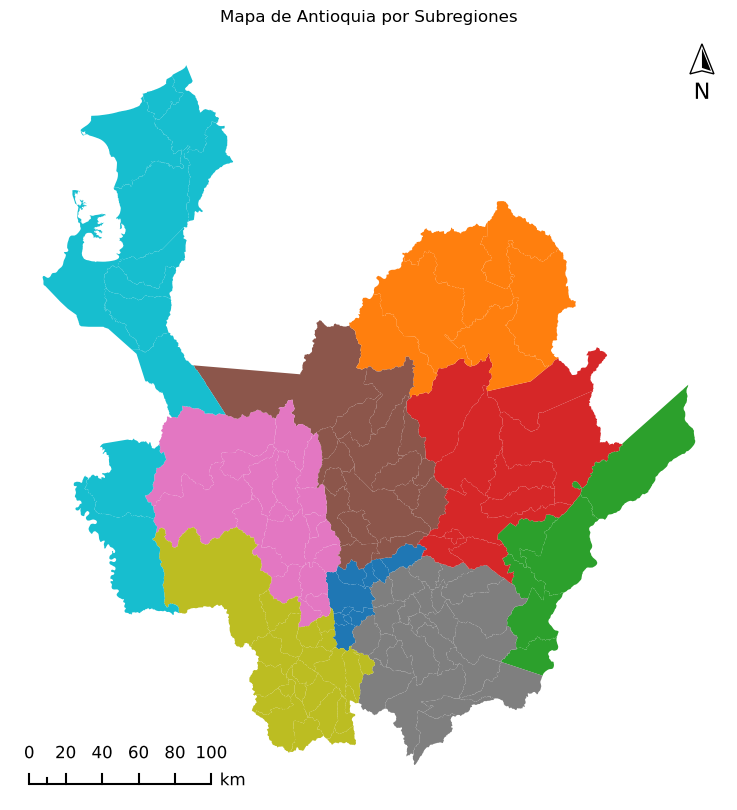

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='codigo_subregion', ax=ax)
north_arrow(ax, location="upper right", rotation={"crs": "EPSG:4326",  "reference": "center"}, scale=0.3, shadow=False)
scale_bar(ax, location="lower left", style="ticks", bar={"projection": 4326})
ScaleBar.set_size(size="sm")
plt.axis('off')
plt.title('Mapa de Antioquia por Subregiones')
plt.show()

## Preprocesamiento de Datos


In [1]:
import unicodedata

In [2]:
def normalize(text):
    nfkd = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd if not unicodedata.combining(c)]).upper()

#### DEM
La información de Altitud media de los municipios de Antioquia fue obtenida del dataset NASA SRTM Digital Elevation 30m disponible en Google Earth Engine a través del siguiente script:
```
// Load zones Polygons
var zones = ee.FeatureCollection("users/algarciach/geo_mpios_antioquia");

// Load SRTM DEM dataset (30m resolution)
var dataset = ee.Image("USGS/SRTMGL1_003");

// Calculate mean DEM elevation by zones
var dem_mean = dataset.reduceRegions({
  collection: zones, 
  reducer: ee.Reducer.mean().setOutputs(['altitud']),
  scale: 30,
});

// Export results as GeoJSON
Export.table.toDrive({
  collection: dem_mean,
  description: 'dem_mpios_antioquia',
  fileFormat: 'GeoJSON'
});

```


In [7]:
dem_mpios_antioquia = gpd.read_file('../Covid19_model/Data/Processed/dem_mpios_antioquia.geojson')
dem_mpios_antioquia.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          125 non-null    object  
 1   altitud     125 non-null    float64 
 2   area_munic  125 non-null    float64 
 3   codigo_mun  125 non-null    object  
 4   nombre_mun  125 non-null    object  
 5   shape_Area  125 non-null    float64 
 6   shape_Leng  125 non-null    float64 
 7   geometry    125 non-null    geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 7.9+ KB


#### Temperature & Relative Humity
La información de Temperatura media anual de los municipios de Antioquia fue obtenida de los datasets WorldClim BIO Variables V1 y la Humedad Relativa media anual fue estimada a partir de los datasets ERA5-Land Monthly - ECMWF Climate Reanalys, ambos disponibles en Google Earth Engine.

```
// Load zones polygons
var zones = ee.FeatureCollection("users/algarciach/geo_mpios_antioquia");

// Load WorldClim V1 BIO1 (Annual Mean Temperature * 10)
var worldclim = ee.Image('WORLDCLIM/V1/BIO')
  .select('bio01')  // BIO1
  .divide(10)       // Convert to °C
  .rename('temperatura');

// Load ERA5-Land Monthly data for 2020
var era5 = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY')
  .filterDate('2020-01-01', '2020-12-31');

// Compute mean temperature and dewpoint (°C)
var temp = era5.select('temperature_2m').mean().subtract(273.15);
var dewpoint = era5.select('dewpoint_temperature_2m').mean().subtract(273.15);

// Constants for Clausius–Clapeyron
var a = 17.625;
var b = 243.04;

// Saturation vapor pressure (es) from temperature
var es = temp.expression(
  '6.112 * exp((a * T) / (b + T))',
  {T: temp, a: a, b: b}
);

// Actual vapor pressure (ea) from dewpoint
var ea = dewpoint.expression(
  '6.112 * exp((a * Td) / (b + Td))',
  {Td: dewpoint, a: a, b: b}
);

// Calculate RH (%), clipped between 0 and 100
var rh = ea.divide(es).multiply(100).max(0).min(100).rename('humedad_relative');

// Combine WorldClim temp and ERA5 RH
var combined = worldclim.addBands(rh);

// Reduce by zones (mean values)
var stats = combined.reduceRegions({
  collection: zones,
  reducer: ee.Reducer.mean(),
  scale: 1000,  // ERA5 native scale approx
});
print(stats)
// Export results as GeoJSON to Google Drive
Export.table.toDrive({
  collection: stats,
  description: 'trh_mpios_antioquia',
  fileFormat: 'GeoJSON'
});


```


In [8]:
trh_mpios_antioquia = gpd.read_file('../Covid19_model/Data/Processed/trh_mpios_antioquia.geojson')
trh_mpios_antioquia.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                125 non-null    object  
 1   area_munic        125 non-null    float64 
 2   codigo_mun        125 non-null    object  
 3   humedad_relative  125 non-null    float64 
 4   nombre_mun        125 non-null    object  
 5   shape_Area        125 non-null    float64 
 6   shape_Leng        125 non-null    float64 
 7   temperatura       125 non-null    float64 
 8   geometry          125 non-null    geometry
dtypes: float64(5), geometry(1), object(3)
memory usage: 8.9+ KB


In [9]:
dem_mpios_antioquia = dem_mpios_antioquia.rename(columns={'codigo_mun': 'codigo_municipio'})
trh_mpios_antioquia = trh_mpios_antioquia.rename(columns={'humedad_relative': 'humedad_relativa', 'codigo_mun': 'codigo_municipio'})

#### Datos Demográficos

In [10]:
poblacion_mpios_antioquia = pd.read_csv('../Covid19_model/Data/Sources/poblacion_antioquia_2024.csv')
poblacion_mpios_antioquia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   codigo_municipio  125 non-null    int64 
 1   nombre_municipio  125 non-null    object
 2   nombre_subregion  125 non-null    object
 3   codigo_subregion  125 non-null    int64 
 4   poblacion         125 non-null    int64 
 5   hombres           125 non-null    int64 
 6   mujeres           125 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 7.0+ KB


In [11]:
poblacion_mpios_antioquia['codigo_municipio'] = poblacion_mpios_antioquia['codigo_municipio'].astype(str).str.zfill(5)
poblacion_mpios_antioquia['codigo_subregion'] = poblacion_mpios_antioquia['codigo_subregion'].astype(str).str.zfill(2)
poblacion_mpios_antioquia['poblacion'] = poblacion_mpios_antioquia['poblacion'].astype(int)
poblacion_mpios_antioquia.info()
poblacion_mpios_antioquia.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   codigo_municipio  125 non-null    object
 1   nombre_municipio  125 non-null    object
 2   nombre_subregion  125 non-null    object
 3   codigo_subregion  125 non-null    object
 4   poblacion         125 non-null    int64 
 5   hombres           125 non-null    int64 
 6   mujeres           125 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 7.0+ KB


,codigo_municipio,nombre_municipio,nombre_subregion,codigo_subregion,poblacion,hombres,mujeres
0,05142,CARACOLI,MAGDALENA MEDIO,03,4824,2417,2407
1,05425,MACEO,MAGDALENA MEDIO,03,8707,4299,4408
2,05579,PUERTO BERRIO,MAGDALENA MEDIO,03,42203,21122,21081
3,05585,PUERTO NARE,MAGDALENA MEDIO,03,15232,7563,7669
4,05591,PUERTO TRIUNFO,MAGDALENA MEDIO,03,19554,10696,8858


In [12]:
poblacion_mpios_antioquia = poblacion_mpios_antioquia.merge(
    dem_mpios_antioquia[['codigo_municipio', 'altitud']],
    on='codigo_municipio',
    how='left'
)
poblacion_mpios_antioquia = poblacion_mpios_antioquia.merge(
    trh_mpios_antioquia[['codigo_municipio', 'temperatura', 'humedad_relativa']],
    on='codigo_municipio',
    how='left'
)

poblacion_mpios_antioquia.info()
poblacion_mpios_antioquia.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_municipio  125 non-null    object 
 1   nombre_municipio  125 non-null    object 
 2   nombre_subregion  125 non-null    object 
 3   codigo_subregion  125 non-null    object 
 4   poblacion         125 non-null    int64  
 5   hombres           125 non-null    int64  
 6   mujeres           125 non-null    int64  
 7   altitud           125 non-null    float64
 8   temperatura       125 non-null    float64
 9   humedad_relativa  125 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 9.9+ KB


,codigo_municipio,nombre_municipio,nombre_subregion,codigo_subregion,poblacion,hombres,mujeres,altitud,temperatura,humedad_relativa
0,05142,CARACOLI,MAGDALENA MEDIO,03,4824,2417,2407,624.071779,25.104725,74.246953
1,05425,MACEO,MAGDALENA MEDIO,03,8707,4299,4408,801.129901,24.064321,75.486478
2,05579,PUERTO BERRIO,MAGDALENA MEDIO,03,42203,21122,21081,302.977808,26.774666,68.166473
3,05585,PUERTO NARE,MAGDALENA MEDIO,03,15232,7563,7669,308.099489,26.793396,68.317391
4,05591,PUERTO TRIUNFO,MAGDALENA MEDIO,03,19554,10696,8858,222.031621,27.299693,63.247296


In [13]:
poblacion_mpios_antioquia.to_csv('../Covid19_model/Data/Processed/poblacion_mpios_antioquia.csv', index=False, encoding='utf-8')

#### Datos Covid19

In [17]:
# Filtrar por casos de COVID-19 en Antioquia
covid19_colombia = pd.read_csv('../Covid19_model/Data/Sources/Casos_positivos_de_COVID-19_en_Colombia._20250404.csv')
covid19_antioquia = covid19_colombia.query("`Nombre departamento` == 'ANTIOQUIA'").copy()
covid19_antioquia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955271 entries, 14 to 6390951
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   fecha reporte web             955271 non-null  object 
 1   ID de caso                    955271 non-null  int64  
 2   Fecha de notificación         955271 non-null  object 
 3   Código DIVIPOLA departamento  955271 non-null  int64  
 4   Nombre departamento           955271 non-null  object 
 5   Código DIVIPOLA municipio     955271 non-null  int64  
 6   Nombre municipio              955271 non-null  object 
 7   Edad                          955271 non-null  int64  
 8   Unidad de medida de edad      955271 non-null  int64  
 9   Sexo                          955271 non-null  object 
 10  Tipo de contagio              955271 non-null  object 
 11  Ubicación del caso            950658 non-null  object 
 12  Estado                        950658 non-null  

In [18]:
covid19_antioquia = covid19_antioquia.rename(columns={
    "fecha reporte web": "fecha_reporte",
    "Código DIVIPOLA municipio": "codigo_municipio",
    "Recuperado": "estado",
    "Edad": "edad",
    "Sexo": "sexo",
})
covid19_antioquia["fecha_reporte"] = pd.to_datetime(covid19_antioquia["fecha_reporte"])
covid19_antioquia["codigo_municipio"] = covid19_antioquia["codigo_municipio"].astype(str).str.zfill(5)
covid19_antioquia["muertes_covid19"] = covid19_antioquia["estado"].apply(lambda x: 1 if x == "Fallecido" else 0)
covid19_antioquia["recuperados_covid19"] = covid19_antioquia["estado"].apply(lambda x: 1 if x == "Recuperado" else 0)
covid19_antioquia = covid19_antioquia[["fecha_reporte", "codigo_municipio", "edad", "sexo", "muertes_covid19", "recuperados_covid19"]]

covid19_antioquia.to_csv('../Covid19_model/Data/Processed/covid19_antioquia.csv', index=False, encoding='utf-8')

In [19]:
covid19_antioquia.info()
covid19_antioquia.head()

<class 'pandas.core.frame.DataFrame'>
Index: 955271 entries, 14 to 6390951
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_reporte        955271 non-null  datetime64[ns]
 1   codigo_municipio     955271 non-null  object        
 2   edad                 955271 non-null  int64         
 3   sexo                 955271 non-null  object        
 4   muertes_covid19      955271 non-null  int64         
 5   recuperados_covid19  955271 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 51.0+ MB


,fecha_reporte,codigo_municipio,edad,sexo,muertes_covid19,recuperados_covid19
14,2020-11-08,05266,37,F,0,1
18,2020-11-08,05266,37,F,0,1
22,2020-11-08,05360,36,F,0,1
31,2020-11-08,05266,63,F,0,1
55,2020-08-05,05001,52,M,0,1


In [20]:
# Filtrar por casos de COVID-19 por municipio
covid19_mpios_antioquia = covid19_antioquia.groupby(['codigo_municipio']).agg({
    'muertes_covid19': 'sum',
    'recuperados_covid19': 'sum'
}).reset_index()

In [21]:
covid19_mpios_antioquia.info()
covid19_mpios_antioquia.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   codigo_municipio     125 non-null    object
 1   muertes_covid19      125 non-null    int64 
 2   recuperados_covid19  125 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ KB


,codigo_municipio,muertes_covid19,recuperados_covid19
0,05001,10354,537729
1,05002,24,579
2,05004,1,78
3,05021,6,176
4,05030,54,1440


#### Datos Geográficos

In [23]:
geo_colombia = gpd.read_file('../Covid19_model/Data/Sources/MGN2024_MPIO_POLITICO/MGN_ADM_MPIO_GRAFICO.shp')
geo_municipios_antioquia = geo_colombia.query("dpto_ccdgo == '05'").copy()

print(geo_municipios_antioquia.crs)
geo_municipios_antioquia.info()

EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 125 entries, 0 to 124
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dpto_ccdgo  125 non-null    object  
 1   mpio_ccdgo  125 non-null    object  
 2   mpio_cdpmp  125 non-null    object  
 3   dpto_cnmbr  125 non-null    object  
 4   mpio_cnmbr  125 non-null    object  
 5   mpio_crslc  125 non-null    object  
 6   mpio_tipo   125 non-null    object  
 7   mpio_narea  125 non-null    float64 
 8   mpio_nano   125 non-null    int32   
 9   shape_Leng  125 non-null    float64 
 10  shape_Area  125 non-null    float64 
 11  geometry    125 non-null    geometry
dtypes: float64(3), geometry(1), int32(1), object(7)
memory usage: 12.2+ KB


In [24]:
municipios_antioquia = geo_municipios_antioquia.rename(columns={"mpio_cdpmp": "codigo_municipio",
                                                          "mpio_cnmbr": "nombre_municipio", "mpio_narea": "area_municipio"})
municipios_antioquia["nombre_municipio"] = municipios_antioquia["nombre_municipio"].apply(normalize)
municipios_antioquia["codigo_municipio"] = municipios_antioquia["codigo_municipio"].astype(str).str.zfill(5)
municipios_antioquia = municipios_antioquia.merge(poblacion_mpios_antioquia[["codigo_subregion", "nombre_subregion", "codigo_municipio"]], on="codigo_municipio", how="left")

municipios_antioquia = municipios_antioquia[["codigo_municipio", "nombre_municipio", "codigo_subregion","nombre_subregion","area_municipio", "geometry"]]
print(municipios_antioquia.crs)
municipios_antioquia.head()


EPSG:4326


,codigo_municipio,nombre_municipio,codigo_subregion,nombre_subregion,area_municipio,geometry
0,05001,MEDELLIN,01,VALLE DE ABURRA,374.834005,"POLYGON ((-75.66974 6.3736, -75.66965 6.3736, ..."
1,05002,ABEJORRAL,07,ORIENTE,507.141095,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05004,ABRIAQUI,06,OCCIDENTE,296.894050,"POLYGON ((-76.08351 6.7505, -76.08325 6.75048,..."
3,05021,ALEJANDRIA,07,ORIENTE,128.932153,"POLYGON ((-75.0332 6.41586, -75.03313 6.41585,..."
4,05030,AMAGA,08,SUROESTE,84.132477,"POLYGON ((-75.67587 6.08561, -75.6754 6.08491,..."


In [25]:
municipios_antioquia.to_file("../Covid19_model/Data/Processed/areas_municipios_antioquia.geojson", driver="GeoJSON")

In [26]:
# Agrupar municipios por subregiones
subregiones_antioquia = municipios_antioquia.dissolve(by="codigo_subregion", as_index=False).reset_index()
subregiones_antioquia = subregiones_antioquia.rename(columns={"codigo_subregion": "codigo_subregion",
                                                              "nombre_subregion": "nombre_subregion",
                                                              "geometry": "geometry"})
subregiones_antioquia["codigo_subregion"] = subregiones_antioquia["codigo_subregion"].astype(str).str.zfill(2)
subregiones_antioquia = subregiones_antioquia[["codigo_subregion", "nombre_subregion", "geometry"]]
print(subregiones_antioquia.crs)
print(subregiones_antioquia.info())
print(subregiones_antioquia.head())


EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   codigo_subregion  9 non-null      object  
 1   nombre_subregion  9 non-null      object  
 2   geometry          9 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 348.0+ bytes
None
  codigo_subregion nombre_subregion  \
0               01  VALLE DE ABURRA   
1               02       BAJO CAUCA   
2               03  MAGDALENA MEDIO   
3               04         NORDESTE   
4               05            NORTE   

                                            geometry  
0  POLYGON ((-75.57241 6.09957, -75.57319 6.09909...  
1  POLYGON ((-75.16579 7.35527, -75.16599 7.35485...  
2  POLYGON ((-74.57163 6.03452, -74.57021 6.02705...  
3  POLYGON ((-74.8388 6.51013, -74.83874 6.51016,...  
4  POLYGON ((-75.48834 6.43038, -75.48941 6.43067...  


In [27]:
subregiones_antioquia.to_file("../Covid19_model/Data/Processed/areas_subregiones_antioquia.geojson", driver="GeoJSON")

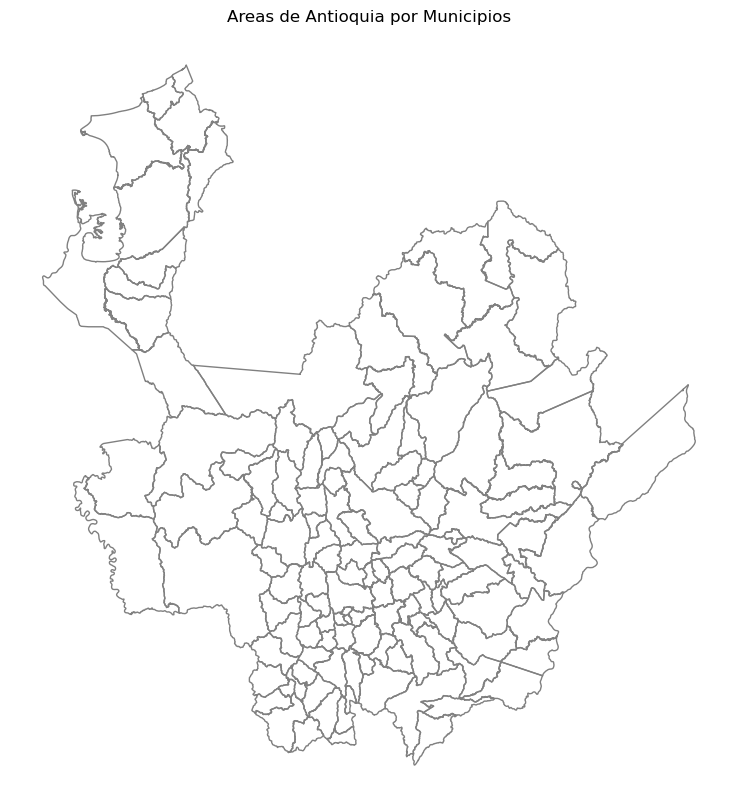

In [31]:
municipios_antioquia.plot(figsize=(10, 10), edgecolor='grey', facecolor='none')
plt.axis('off')
plt.title('Areas de Antioquia por Municipios')   
plt.show()

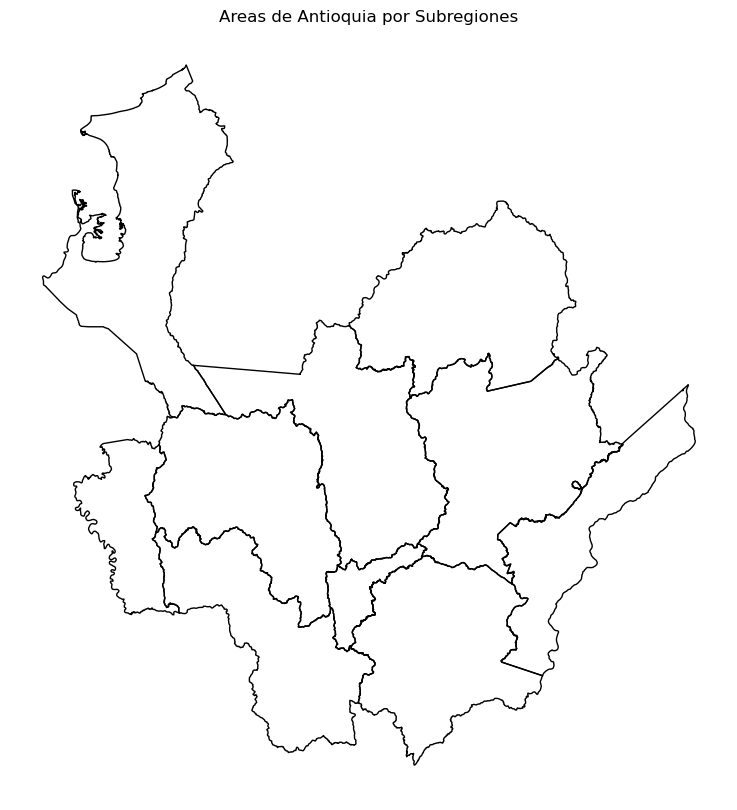

In [32]:
subregiones_antioquia.plot(figsize=(10, 10), edgecolor='black', facecolor='none')
plt.axis('off')
plt.title('Areas de Antioquia por Subregiones')
plt.show()

#### Unir datos Demográficos y Covid19 con Geográficos

In [33]:
covid19_municipios_antioquia = municipios_antioquia.merge(
    poblacion_mpios_antioquia[['codigo_municipio', "poblacion", "altitud", "temperatura", "humedad_relativa"]],
    on='codigo_municipio',
    how='left'
)
covid19_municipios_antioquia = covid19_municipios_antioquia.merge(
    covid19_mpios_antioquia,
    on='codigo_municipio',
    how='left'
)

covid19_municipios_antioquia["densidad"] = covid19_municipios_antioquia["poblacion"] / covid19_municipios_antioquia["area_municipio"]
covid19_municipios_antioquia["cfr"] = (covid19_municipios_antioquia["muertes_covid19"] / (covid19_municipios_antioquia["muertes_covid19"] + covid19_municipios_antioquia["recuperados_covid19"])) * 100

covid19_municipios_antioquia = covid19_municipios_antioquia[["codigo_municipio", "nombre_municipio", "codigo_subregion", "nombre_subregion", "area_municipio", "altitud", "temperatura", "humedad_relativa", "poblacion", "densidad", "muertes_covid19", "recuperados_covid19", "cfr", "geometry"]]

covid19_municipios_antioquia.info()
covid19_municipios_antioquia.head(10)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory usage: 13.8

,codigo_municipio,nombre_municipio,codigo_subregion,nombre_subregion,area_municipio,altitud,temperatura,humedad_relativa,poblacion,densidad,muertes_covid19,recuperados_covid19,cfr,geometry
0,05001,MEDELLIN,01,VALLE DE ABURRA,374.834005,2059.003077,18.203481,80.582299,2616335,6979.983054,10354,537729,1.889130,"POLYGON ((-75.66974 6.3736, -75.66965 6.3736, ..."
1,05002,ABEJORRAL,07,ORIENTE,507.141095,1947.128522,17.845754,80.265871,21468,42.331415,24,579,3.980100,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05004,ABRIAQUI,06,OCCIDENTE,296.894050,2371.335448,15.912880,85.717115,2855,9.616225,1,78,1.265823,"POLYGON ((-76.08351 6.7505, -76.08325 6.75048,..."
3,05021,ALEJANDRIA,07,ORIENTE,128.932153,1545.100614,20.538783,80.036523,4955,38.431065,6,176,3.296703,"POLYGON ((-75.0332 6.41586, -75.03313 6.41585,..."
4,05030,AMAGA,08,SUROESTE,84.132477,1513.740970,21.093243,78.477931,32412,385.249562,54,1440,3.614458,"POLYGON ((-75.67587 6.08561, -75.6754 6.08491,..."
5,05031,AMALFI,04,NORDESTE,1209.145462,1092.076758,22.556800,82.154404,27846,23.029487,33,841,3.775744,"POLYGON ((-74.85309 7.14256, -74.85313 7.14237..."
6,05034,ANDES,08,SUROESTE,402.465966,2118.572025,16.769616,84.008345,46183,114.750075,51,1416,3.476483,"POLYGON ((-75.86822 5.75753, -75.86827 5.75673..."
7,05036,ANGELOPOLIS,08,SUROESTE,81.876302,1805.109039,19.662195,77.647880,6109,74.612554,6,135,4.255319,"POLYGON ((-75.69149 6.1932, -75.6908 6.19319, ..."
8,05038,ANGOSTURA,05,NORTE,338.502287,2066.395558,17.746139,85.343289,12121,35.807734,3,180,1.639344,"POLYGON ((-75.27173 6.97094, -75.27164 6.9709,..."
9,05040,ANORI,04,NORDESTE,1413.775719,925.024037,23.209307,84.477787,19675,13.916635,15,302,4.731861,"POLYGON ((-74.90935 7.45001, -74.9091 7.45001,..."


In [34]:
covid19_municipios_antioquia.to_file("../Covid19_model/Data/covid19_municipios_antioquia.gpkg", driver='GPKG', layer='covid19_municipios_antioquia')


EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory u

Text(0.5, 1.0, 'Tasa de letalidad por COVID-19 en Antioquia por municipio')

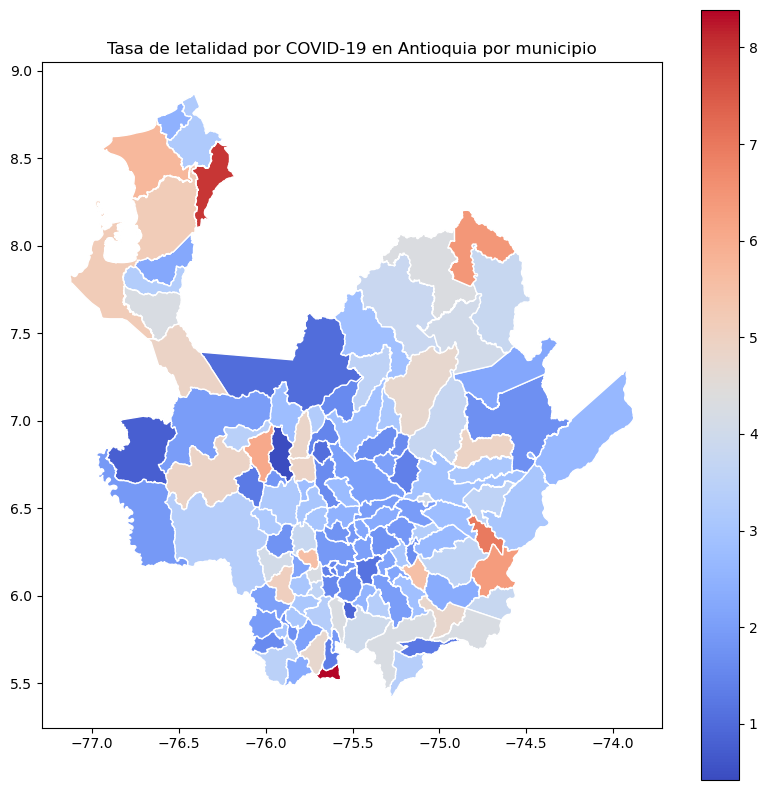

In [36]:
covid19_municipios_antioquia = gpd.read_file("../Covid19_model/Data/covid19_municipios_antioquia.gpkg")
print(covid19_municipios_antioquia.crs)
covid19_municipios_antioquia.info()
covid19_municipios_antioquia.head(10)   
fig, ax = plt.subplots(figsize=(10, 10))    
covid19_municipios_antioquia.plot(column="cfr", cmap="coolwarm", legend=True, ax=ax, edgecolor='white')
plt.title("Tasa de letalidad por COVID-19 en Antioquia por municipio")